# Improving Integral from ClusterAbundance prediction

In [1]:
import os
import pyccl as ccl
from typing import Any, Dict
import numpy as np

from firecrown.models.cluster_abundance import ClusterAbundance
from firecrown.models.cluster_mass_rich_proxy import ClusterMassRich, ClusterMassRichBinArgument, ClusterMassRichPointArgument
from firecrown.models.cluster_redshift_spec import ClusterRedshiftSpec, ClusterRedshiftSpecArgument
from firecrown.models.cluster_mass import ClusterMassArgument
from firecrown.models.cluster_redshift import ClusterRedshiftArgument
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import interp1d
import time

## Preparation of Cluster Objects

In [2]:
Omega_c = 0.262
Omega_b = 0.049
Omega_k = 0.0
H0 = 67.66
h = H0 / 100.0
Tcmb0 = 2.7255
A_s = 2.1e-9
sigma8 = 0.8277
n_s = 0.96
Neff = 3.046
w0 = -1.0
wa = 0.0


In [3]:
cosmo_ccl = ccl.Cosmology(
    Omega_c=Omega_c,
    Omega_b=Omega_b,
    Neff=Neff,
    h=h,
    sigma8=sigma8,
    n_s=n_s,
    Omega_k=Omega_k,
    w0=w0,
    wa=wa,
    T_CMB=Tcmb0,
    m_nu=[0.00, 0.0, 0.0]
)
pivot_mass = 14.625862906
pivot_redshift = 0.6

cluster_mass_r = ClusterMassRich(pivot_mass, pivot_redshift)

cluster_mass_r.__setattr__("mu_p0", 3.0)
cluster_mass_r.__setattr__("mu_p1", .86)
cluster_mass_r.__setattr__("mu_p2", .0)
cluster_mass_r.__setattr__("sigma_p0", 3.0)
cluster_mass_r.__setattr__("sigma_p1", .7)
cluster_mass_r.__setattr__("sigma_p2", 0.0)

cluster_z = ClusterRedshiftSpec()
# 3 - `ClusterAbundance`
hmd_200 = ccl.halos.MassDef200m()
hmf_args: Dict[str, Any] = {}
hmf_name = "Tinker08"



## Substituting the Redshift integral for an interpolation

For the problem in hand, we have a 3-dimensional integral in richness, mass and redshift. The richness integral has an analytical solution givne by the error function. In this notebook, we want to replace one of the two remaining integrals by an 1-dimensional interpolation. We will first replace the redshift intergral and than the mass integral.

Thus, in the first case, we will use the analytical function for the richness integral and integrate over mass for given points of redshift in the bin range. We will use these results to compute an interpolation that will later be integrated as well.

In [4]:
class ClusterAbundanceTestZ(ClusterAbundance):

    def __init__(
        self,
        halo_mass_definition: ccl.halos.MassDef,
        halo_mass_function_name: str,
        halo_mass_function_args: Dict[str, Any],
        sky_area: float = 100.0,
        use_completness: bool = False,
        use_purity: bool = False,
        interp_points = 10
    ):
        super().__init__(halo_mass_definition, halo_mass_function_name, halo_mass_function_args)
        self.interp_points = interp_points

    def _compute_any_from_args(
        self,
        integrand,
        ccl_cosmo: ccl.Cosmology,
        mass_arg: ClusterMassArgument,
        redshift_arg: ClusterRedshiftArgument,
    ) -> float:
        last_index = 0
        arg = np.zeros(2 + mass_arg.dim + redshift_arg.dim)
        index_map: List[int] = []
        bounds_list: List[Tuple[float, float]] = []

        if mass_arg.is_dirac_delta():
            arg[0] = mass_arg.get_logM()
        else:
            index_map.append(last_index)
            bounds_list.append(mass_arg.get_logM_bounds())
        last_index += 1

        if True:#for z
            last_index += 1

        if mass_arg.dim > 0:
            index_map += list(range(last_index, last_index + mass_arg.dim))
            bounds_list += mass_arg.get_proxy_bounds()

        last_index += mass_arg.dim

        if len(index_map) == 0:
            # No proxy bins
            return (
                self.mf_d2N_dz_dlnM(ccl_cosmo, arg[0], arg[1])
                * mass_arg.p(arg[0], arg[1])
                * redshift_arg.p(arg[0], arg[1])
            )
        z_bounds = redshift_arg.get_z_bounds()
        z_list = np.linspace(z_bounds[0], z_bounds[1], self.interp_points)
        final_list = []
        for z_i in z_list:
            arg[1] = z_i
            counts_i =  scipy.integrate.nquad(
                integrand,
                args=(index_map, arg, ccl_cosmo, mass_arg, redshift_arg),
                ranges=bounds_list,
                opts={"epsabs": 0.0, "epsrel": 1.0e-4},
            )[0]
            final_list.append(counts_i)
        f_interp = interp1d(z_list, final_list)
        return np.trapz(f_interp(z_list), z_list, (z_bounds[1] - z_bounds[0]) / self.interp_points)

## Substituting the Mass integral for an interpolation

In this approach, we will follow the same path by using the analytical function for the richness integral and integrating over redshift for different values of masses. The results will be used to create an interpolation over mass, which will then be integrated as well.

In [5]:
class ClusterAbundanceTestM(ClusterAbundance):

    def __init__(
        self,
        halo_mass_definition: ccl.halos.MassDef,
        halo_mass_function_name: str,
        halo_mass_function_args: Dict[str, Any],
        sky_area: float = 100.0,
        use_completness: bool = False,
        use_purity: bool = False,
        interp_points = 10
    ):
        super().__init__(halo_mass_definition, halo_mass_function_name, halo_mass_function_args)
        self.interp_points = interp_points
    def _compute_any_from_args(
        self,
        integrand,
        ccl_cosmo: ccl.Cosmology,
        mass_arg: ClusterMassArgument,
        redshift_arg: ClusterRedshiftArgument,
    ) -> float:
        last_index = 0
        z_test = 1.0
        arg = np.zeros(2 + mass_arg.dim + redshift_arg.dim)
        index_map: List[int] = []
        bounds_list: List[Tuple[float, float]] = []
        if True:#for m
            last_index += 1
            
        if redshift_arg.is_dirac_delta():
            arg[1] = redshift_arg.get_z()
        else:
            index_map.append(last_index)
            bounds_list.append(redshift_arg.get_z_bounds())
        last_index += 1

        if redshift_arg.dim > 0:
            index_map += list(range(last_index, last_index + redshift_arg.dim))
            bounds_list += redshift_arg.get_proxy_bounds()
        last_index += redshift_arg.dim

        if len(index_map) == 0:
            # No proxy bins
            return (
                self.mf_d2N_dz_dlnM(ccl_cosmo, arg[0], arg[1])
                * mass_arg.p(arg[0], arg[1])
                * redshift_arg.p(arg[0], arg[1])
            )
        logM_bounds = mass_arg.get_logM_bounds()
        logM_list = np.linspace(logM_bounds[0], logM_bounds[1], self.interp_points)
        final_list = []
        for logM_i in logM_list:
            arg[0] = logM_i
            counts_i =  scipy.integrate.nquad(
                integrand,
                args=(index_map, arg, ccl_cosmo, mass_arg, redshift_arg),
                ranges=bounds_list,
                opts={"epsabs": 0.0, "epsrel": 1.0e-4},
            )[0]
            final_list.append(counts_i)
        f_interp = interp1d(logM_list, final_list)
        return np.trapz(f_interp(logM_list), logM_list, (logM_bounds[1] - logM_bounds[0]) / self.interp_points)

# Comparison between the methods

We will compute the counts prediction using the integral method (called normal), the z- interpolation method and the mass interpolation method. We aim to compare the precision and computation time between the methods, assuming the first one to be the fiducial model, while varying the amount of points used to generate the interpolation.

In the following cells, we do a first test for 10 points used in the interpolation.

## Computing normal prediction

In [6]:
cluster_abundance_normal = ClusterAbundance(hmd_200, hmf_name, hmf_args)
z_bins = np.linspace(0.0, 1.0, 4)
r_bins = np.linspace(1.0, 2.5, 5)
cluster_counts_list = []
t1 = time.time()
for i in range(0,3):
    for j in range(0,4):
        bin_ij = ((z_bins[i], z_bins[i+1]),(r_bins[j], r_bins[j+1]))
        cluster_mass_bin = ClusterMassRichBinArgument(cluster_mass_r, 13,15, r_bins[j], r_bins[j+1])
        cluster_z_bin = ClusterRedshiftSpecArgument(z_bins[i], z_bins[i+1])
        cluster_counts =cluster_abundance_normal.compute(cosmo_ccl, cluster_mass_bin, cluster_z_bin)
        cluster_counts_list.append(cluster_counts)
t2 = time.time()
print(f"The predictions of clusters in each bin is {cluster_counts_list}")
print(t2 - t1)



The predictions of clusters in each bin is [239.08028083312462, 117.62461552740133, 58.673712759167984, 29.401592288829168, 924.1733162612882, 431.0462830172569, 203.56022290471452, 96.47939297212574, 1155.6220311710492, 502.3188869523067, 220.7193203429698, 97.20179341249663]
2.6228926181793213


## Computing prediction with Z interpolation 

In [7]:
abundance_z_test = ClusterAbundanceTestZ(hmd_200, hmf_name, hmf_args)
z_bins = np.linspace(0.0, 1.0, 4)
r_bins = np.linspace(1.0, 2.5, 5)
test_z_list = []
t3 = time.time()
for i in range(0,3):
    for j in range(0,4):
        bin_ij = ((z_bins[i], z_bins[i+1]),(r_bins[j], r_bins[j+1]))
        cluster_mass_bin = ClusterMassRichBinArgument(cluster_mass_r, 13,15, r_bins[j], r_bins[j+1])
        cluster_z_bin = ClusterRedshiftSpecArgument(z_bins[i], z_bins[i+1])
        cluster_counts =abundance_z_test.compute(cosmo_ccl, cluster_mass_bin, cluster_z_bin)
        test_z_list.append(cluster_counts)
t4 = time.time()
print(f"The predictions of clusters in each bin is {test_z_list} \n")
print(f"The total time was {t4 - t3}")




The predictions of clusters in each bin is [239.89897464756137, 118.00173385726688, 58.84897437043607, 29.48301900488345, 923.5776155383348, 430.73018719330446, 203.39424346095183, 96.39352217440712, 1155.1283731211565, 502.1060462592266, 220.62940899937192, 97.16508343318917] 

The total time was 1.015202283859253


## Computing prediction with M interpolation 

In [8]:
abundance_test = ClusterAbundanceTestM(hmd_200, hmf_name, hmf_args)
test_m_list = []
t5 = time.time()
for i in range(0,3):
    for j in range(0,4):
        bin_ij = ((z_bins[i], z_bins[i+1]),(r_bins[j], r_bins[j+1]))
        cluster_mass_bin = ClusterMassRichBinArgument(cluster_mass_r, 13,15, r_bins[j], r_bins[j+1])
        cluster_z_bin = ClusterRedshiftSpecArgument(z_bins[i], z_bins[i+1])
        cluster_counts =abundance_test.compute(cosmo_ccl, cluster_mass_bin, cluster_z_bin)
        test_m_list.append(cluster_counts)
t6 = time.time()
print(f"The predictions of clusters in each bin is {test_m_list} \n")
print(f"The total time was {t6 - t5}\n\n")

print(f"The time for the normal prediction is {t2-t1} \nThe time for the z-interpolation is{t4-t3} \nThe time for the m-interpolation is {t6-t5}")

The predictions of clusters in each bin is [238.7705518368292, 117.63293275308988, 58.61745982953258, 29.365597384668202, 922.8278847864132, 431.2150693338295, 203.42221605542608, 96.42083324435836, 1153.5082334052836, 502.6912202139817, 220.59822529972976, 97.19280519600741] 

The total time was 0.3553473949432373


The time for the normal prediction is 2.6228926181793213 
The time for the z-interpolation is1.015202283859253 
The time for the m-interpolation is 0.3553473949432373


## Plots of errors and number of points for interpolation

In [9]:
points_list = [5*i for i in range (1,20)]
test_z_final = []
test_m_final = []
for k in points_list:
    abundance_test_z = ClusterAbundanceTestZ(hmd_200, hmf_name, hmf_args, interp_points=k)
    abundance_test_m = ClusterAbundanceTestM(hmd_200, hmf_name, hmf_args, interp_points=k)
    test_m_list = []
    test_z_list = []
    t5 = time.time()
    for i in range(0,3):
        for j in range(0,4):
            bin_ij = ((z_bins[i], z_bins[i+1]),(r_bins[j], r_bins[j+1]))
            cluster_mass_bin = ClusterMassRichBinArgument(cluster_mass_r, 13,15, r_bins[j], r_bins[j+1])
            cluster_z_bin = ClusterRedshiftSpecArgument(z_bins[i], z_bins[i+1])
            cluster_counts =abundance_test_z.compute(cosmo_ccl, cluster_mass_bin, cluster_z_bin)
            test_z_list.append(cluster_counts)
    t6 = time.time()
    test_z_final.append((t6-t5,test_z_list))
    t7 = time.time()
    for i in range(0,3):
        for j in range(0,4):
            bin_ij = ((z_bins[i], z_bins[i+1]),(r_bins[j], r_bins[j+1]))
            cluster_mass_bin = ClusterMassRichBinArgument(cluster_mass_r, 13,15, r_bins[j], r_bins[j+1])
            cluster_z_bin = ClusterRedshiftSpecArgument(z_bins[i], z_bins[i+1])
            cluster_counts =abundance_test_m.compute(cosmo_ccl, cluster_mass_bin, cluster_z_bin)
            test_m_list.append(cluster_counts)
    t8 = time.time()
    test_m_final.append((t8-t7, test_m_list))


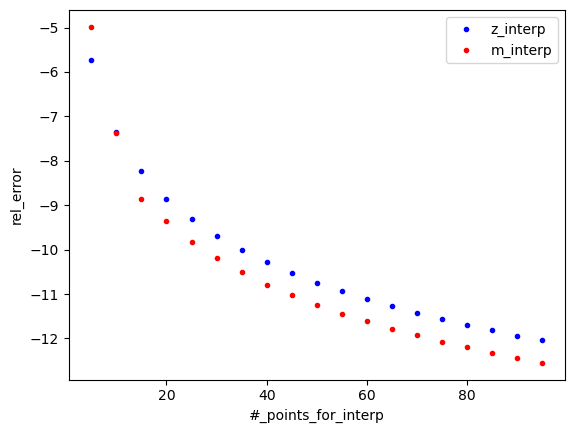

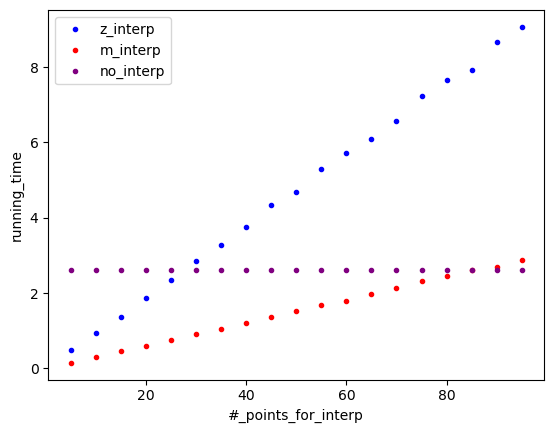

In [10]:
time_z = []
time_m = []
error_z = []
error_m = []
t = [t2-t1 for a in range (0, len(points_list))] 
for time_i, list_i in test_z_final:    
    time_z.append(time_i)
    error_z.append( np.log(np.mean((np.array(list_i) - np.array(cluster_counts_list)) / np.array(cluster_counts_list))))
for time_i, list_i in test_m_final:
    time_m.append(time_i)
    error_m.append(np.log(abs(np.mean((np.array(list_i) - np.array(cluster_counts_list)) / np.array(cluster_counts_list)))))
plt.plot(points_list, error_z, '.', color='blue', label='z_interp')
plt.plot(points_list, error_m, '.', color='red', label='m_interp')
plt.xlabel('#_points_for_interp')
plt.ylabel('rel_error')
plt.legend()
plt.show()
plt.plot(points_list, time_z, '.', color='blue', label='z_interp')
plt.plot(points_list, time_m, '.', color='red', label='m_interp')
plt.plot(points_list, t, '.', color='purple', label='no_interp')
plt.xlabel('#_points_for_interp')
plt.ylabel('running_time')
plt.legend()
plt.show()


# Conclusion

The m-interpolation shows to be the best approach, as it improves the computation time in ~8 times, while maintaining the precision even with 5 points for the interpolation. 